In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import math

In [2]:
TARGET_SLICE_COUNT = 64  # Number of slices per patient
TARGET_SLICE_DIMENSIONS = (128, 128)  # Dimensions of each slice

In [3]:
# Load preprocessed data
X_train3 = np.load("/kaggle/input/3d-ct-scan-dataset/X_train3.npy")
y_train3 = np.load("/kaggle/input/3d-ct-scan-dataset/y_train3.npy")
X_valid3 = np.load("/kaggle/input/3d-ct-scan-dataset/X_valid3.npy")
y_valid3 = np.load("/kaggle/input/3d-ct-scan-dataset/y_valid3.npy")

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Reshape

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape

# Define the Model
combined_model = Sequential([
    # 3D Convolutional Layers
    Conv3D(32, (3, 3, 3), activation="relu", padding="same", input_shape=(TARGET_SLICE_COUNT, *TARGET_SLICE_DIMENSIONS, 1)),
    MaxPooling3D(pool_size=(2, 2, 2)),
    Dropout(0.2),

    Conv3D(64, (3, 3, 3), activation="relu", padding="same"),
    MaxPooling3D(pool_size=(2, 2, 2)),
    Dropout(0.3),

    Conv3D(128, (3, 3, 3), activation="relu", padding="same"),
    MaxPooling3D(pool_size=(2, 2, 2)),  # Depth might now be 1

    # Transition to 2D Convolution
    Reshape((-1, TARGET_SLICE_DIMENSIONS[0] // 8, 128)),  # Flatten depth into batch
    Conv2D(128, (3, 3), activation="relu", padding="same"),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Conv2D(256, (3, 3), activation="relu", padding="same"),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    # Fully Connected Layers
    Flatten(),
    Dense(512, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")  # Binary classification
])

In [11]:
# Compile the Model
combined_model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy", "Precision", "Recall", "AUC"])

In [12]:
combined_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_3 (Conv3D)               │ (None, 64, 128, 128,   │           896 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 32, 64, 64, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32, 64, 64, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 32, 64, 64, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 16, 32, 32, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16, 32, 32, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 16, 32, 32,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 8, 16, 16, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 128, 16, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 16, 128)   │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 8, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64, 8, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 8, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 4, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32, 4, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,498,561 (66.75 MB)

 Trainable params: 17,498,561 (66.75 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Assuming `train_data` and `val_data` are prepared
history2 = combined_model.fit(X_train3, y_train3,
                    validation_data=(X_valid3, y_valid3),
                    epochs=30,
                    verbose=1)

Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 11s/step - AUC: 0.6515 - Precision: 0.6190 - Recall: 0.6562 - accuracy: 0.6448 - loss: 4710.6992 - val_AUC: 0.5000 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.4783 - val_loss: 39.3894
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - AUC: 0.5362 - Precision: 0.4844 - Recall: 0.4246 - accuracy: 0.5562 - loss: 204.7519 - val_AUC: 0.5000 - val_Precision: 0.5217 - val_Recall: 1.0000 - val_accuracy: 0.5217 - val_loss: 55.1002
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - AUC: 0.5000 - Precision: 0.4830 - Recall: 1.0000 - accuracy: 0.4830 - loss: 231.2382 - val_AUC: 0.5000 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.4783 - val_loss: 14.9374
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - AUC: 0.4602 - Precision: 0.4444 - Recall: 0.1529 - accuracy: 0.4700 - loss: 37.0706 - val_AUC: 0.2045 - val_Precision: 0.3125 - val_Recall: 0.4167 - val_accuracy: 0.2174 - val_loss: 1.8717
Epoch 5/30
2/2 ━━━━━━━━

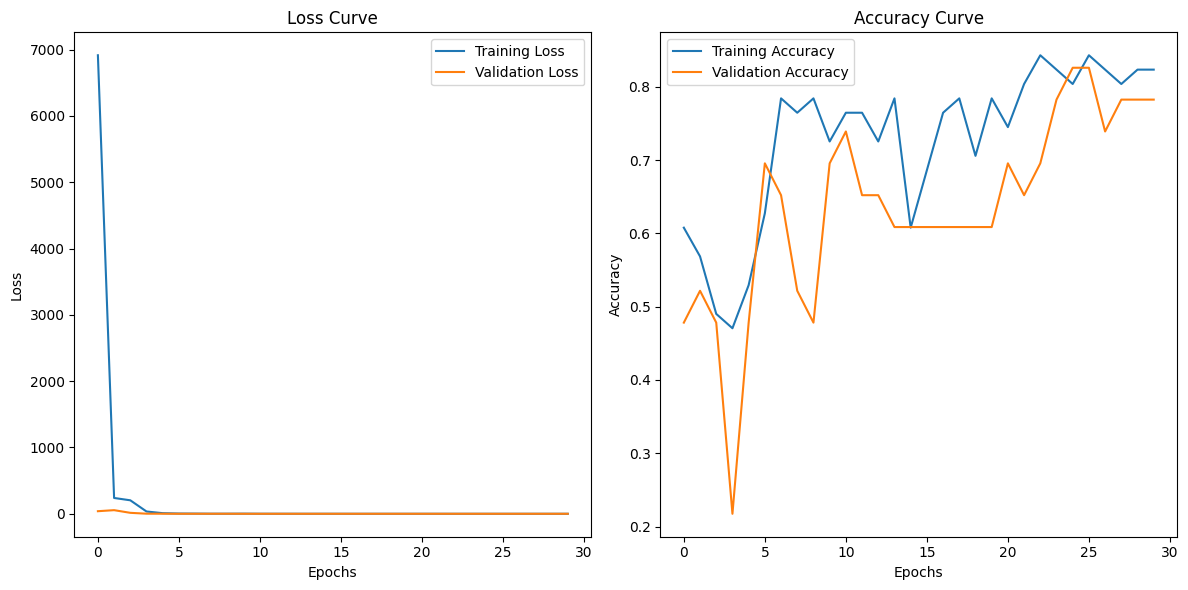

In [14]:

# Plotting training curves
def plot_training_curves(history):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot loss
    axs[0].plot(history.history['loss'], label="Training Loss")
    axs[0].plot(history.history['val_loss'], label="Validation Loss")
    axs[0].set_title("Loss Curve")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    # Plot accuracy
    axs[1].plot(history.history['accuracy'], label="Training Accuracy")
    axs[1].plot(history.history['val_accuracy'], label="Validation Accuracy")
    axs[1].set_title("Accuracy Curve")
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()

    plt.tight_layout()
    plt.show()

plot_training_curves(history2)